In [7]:
import pandas as pd
import random
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import warnings
import os
import transformers
from transformers import AutoTokenizer, TFAutoModel,TFBertForSequenceClassification, TFAutoModelForSequenceClassification,TFBertMainLayer,TFBertPreTrainedModel, PreTrainedTokenizerFast
warnings.filterwarnings("ignore")
from tensorflow.keras import layers, models
from sklearn.metrics import f1_score, accuracy_score, classification_report, multilabel_confusion_matrix, ConfusionMatrixDisplay, PrecisionRecallDisplay
import random
import os



c:\Users\edoar.EDO\anaconda3\envs\rl_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def set_reproducibility(seed):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    transformers.set_seed(seed)
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

set_reproducibility(42)


In [ ]:
#for colab
from google.colab import files
import zipfile


uploaded = files.upload()


zip_filename = next(iter(uploaded))


with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall('/content/')  

path_labels_data = "./labels_data"
path_arguments_data = "./arguments_data"

In [8]:
path_labels_data = ".\labels_data"
path_arguments_data = ".\\arguments_data"

# 1. Corpus

In [9]:
def load_file():
    '''Load the file and return the data and labels for training, testing and validation'''
    
    train_data = pd.read_csv(os.path.join(path_arguments_data, 'arguments-training.tsv'), sep='\t')
    test_data = pd.read_csv(os.path.join(path_arguments_data, 'arguments-test.tsv'), sep='\t')
    valid_data = pd.read_csv(os.path.join(path_arguments_data, 'arguments-validation.tsv'), sep='\t')
    train_labels = pd.read_csv(os.path.join(path_labels_data, 'labels-training.tsv'),sep='\t')
    test_labels = pd.read_csv(os.path.join(path_labels_data, 'labels-test.tsv'),sep='\t')
    valid_labels = pd.read_csv(os.path.join(path_labels_data, 'labels-validation.tsv'),sep='\t')

    return (train_data,train_labels), (test_data,test_labels), (valid_data,valid_labels)
    



(train_data,train_labels), (test_data,test_labels), (valid_data,valid_labels) = load_file()

print("Trainig data shape: ", train_data.shape)
print("Validation data shape: ", valid_data.shape)
print("Test data shape: ", test_data.shape)

print("Level 2 Classes: ", len(train_labels.columns[1:]))

Trainig data shape:  (5393, 4)
Validation data shape:  (1896, 4)
Test data shape:  (1576, 4)
Level 2 Classes:  20


In [6]:
train_data.head()

,Argument ID,Conclusion,Stance,Premise
0,A01002,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...
1,A01005,We should ban fast food,in favor of,fast food should be banned because it is reall...
2,A01006,We should end the use of economic sanctions,against,sometimes economic sanctions are the only thin...
3,A01007,We should abolish capital punishment,against,capital punishment is sometimes the only optio...
4,A01008,We should ban factory farming,against,factory farming allows for the production of c...


In [7]:
train_labels.head()

,Argument ID,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,Power: resources,Face,Security: personal,...,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
0,A01002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,A01005,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,A01006,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,A01007,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
4,A01008,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,1,0,0,0


In [8]:
train_labels.columns


Index(['Argument ID', 'Self-direction: thought', 'Self-direction: action',
       'Stimulation', 'Hedonism', 'Achievement', 'Power: dominance',
       'Power: resources', 'Face', 'Security: personal', 'Security: societal',
       'Tradition', 'Conformity: rules', 'Conformity: interpersonal',
       'Humility', 'Benevolence: caring', 'Benevolence: dependability',
       'Universalism: concern', 'Universalism: nature',
       'Universalism: tolerance', 'Universalism: objectivity'],
      dtype='object')

In [10]:
def merge_df(data, labels):
    return pd.merge(data, labels, on='Argument ID')

In [11]:
l2_train_df = merge_df(train_data, train_labels)
l2_test_df = merge_df(test_data, test_labels)
l2_valid_df = merge_df(valid_data, valid_labels)


In [11]:
l2_train_df.shape

(5393, 24)

In [12]:
datasets = {"Training":l2_train_df, "Validation":l2_valid_df, "Test":l2_test_df}
for i,key in enumerate(datasets.keys()):
    print(f"Number of null values in {key} set: ", datasets[key].isnull().sum().sum())

Number of null values in Training set:  0
Number of null values in Validation set:  0
Number of null values in Test set:  0


In [13]:
for column in l2_train_df.iloc[:,4:].columns:
    print(f"Unique values taken by \"{column}\" label: {np.unique(l2_train_df[column].values)}, number = {l2_train_df[column].nunique()}")
    


Unique values taken by "Self-direction: thought" label: [0 1], number = 2
Unique values taken by "Self-direction: action" label: [0 1], number = 2
Unique values taken by "Stimulation" label: [0 1], number = 2
Unique values taken by "Hedonism" label: [0 1], number = 2
Unique values taken by "Achievement" label: [0 1], number = 2
Unique values taken by "Power: dominance" label: [0 1], number = 2
Unique values taken by "Power: resources" label: [0 1], number = 2
Unique values taken by "Face" label: [0 1], number = 2
Unique values taken by "Security: personal" label: [0 1], number = 2
Unique values taken by "Security: societal" label: [0 1], number = 2
Unique values taken by "Tradition" label: [0 1], number = 2
Unique values taken by "Conformity: rules" label: [0 1], number = 2
Unique values taken by "Conformity: interpersonal" label: [0 1], number = 2
Unique values taken by "Humility" label: [0 1], number = 2
Unique values taken by "Benevolence: caring" label: [0 1], number = 2
Unique val

In [14]:
l2_train_df.head()

,Argument ID,Conclusion,Stance,Premise,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,...,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
0,A01002,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,A01005,We should ban fast food,in favor of,fast food should be banned because it is reall...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,A01006,We should end the use of economic sanctions,against,sometimes economic sanctions are the only thin...,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,A01007,We should abolish capital punishment,against,capital punishment is sometimes the only optio...,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
4,A01008,We should ban factory farming,against,factory farming allows for the production of c...,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0


In [12]:
level2_to_level3 = {
    'Openness to change':["Self-direction: thought", "Self-direction: action","Stimulation", "Hedonism"],
    "Self-enhancement":['Hedonism','Achievement', 'Power: dominance', 'Power: resources','Face'],
    "Conservation": ['Face', 'Security: personal', 'Security: societal', 'Tradition', 'Conformity: rules', 'Conformity: interpersonal','Humility'],
    "Self-transcendence":['Humility', 'Benevolence: caring', 'Benevolence: dependability','Universalism: concern', 'Universalism: nature','Universalism: tolerance', 'Universalism: objectivity']
}

    

In [13]:
counts_train = l2_train_df.iloc[:,4:].eq(1).sum()
total_counts_train = counts_train.sum()
print("Count of Level 2 category in Training Dataset: \n\n{}".format(counts_train))
print("\nTotal count of Level 2 categories in Training Dataset: {}".format(total_counts_train))

Count of Level 2 category in Training Dataset: 

Self-direction: thought        988
Self-direction: action        1395
Stimulation                    247
Hedonism                       172
Achievement                   1512
Power: dominance               610
Power: resources               625
Face                           382
Security: personal            2000
Security: societal            1728
Tradition                      568
Conformity: rules             1177
Conformity: interpersonal      207
Humility                       395
Benevolence: caring           1332
Benevolence: dependability     806
Universalism: concern         2081
Universalism: nature           427
Universalism: tolerance        664
Universalism: objectivity     1054
dtype: int64

Total count of Level 2 categories in Training Dataset: 18370


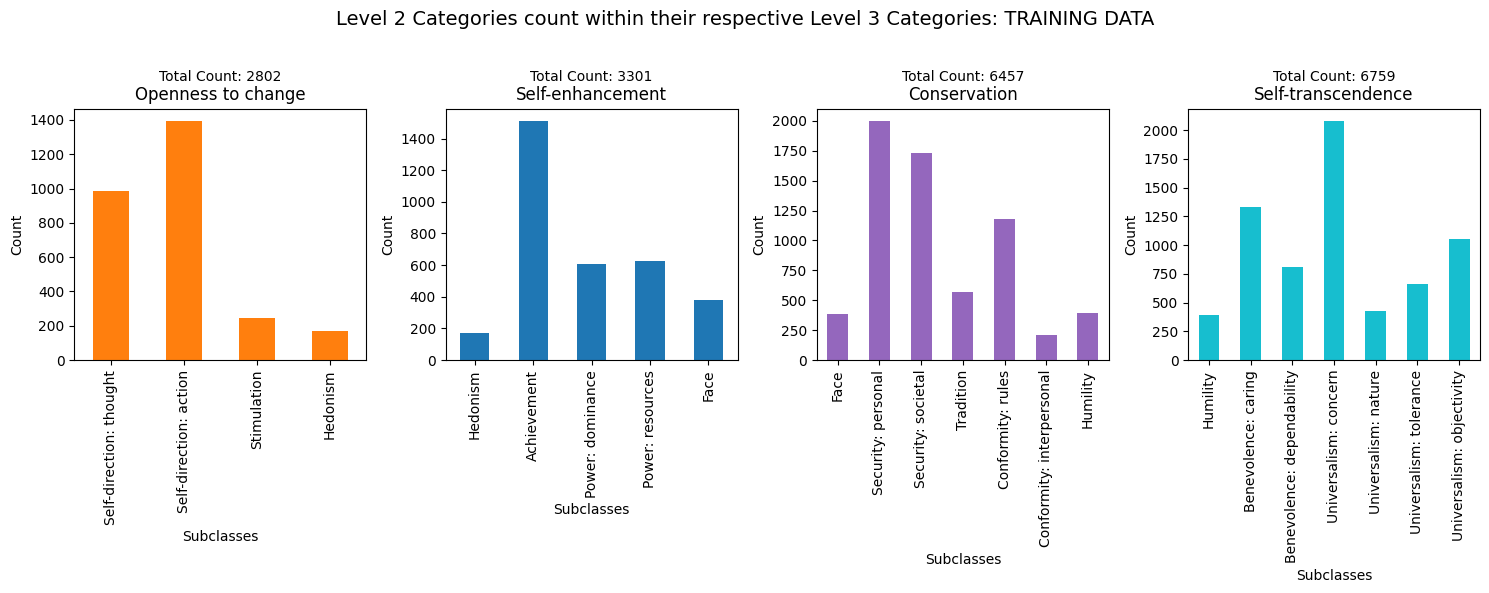

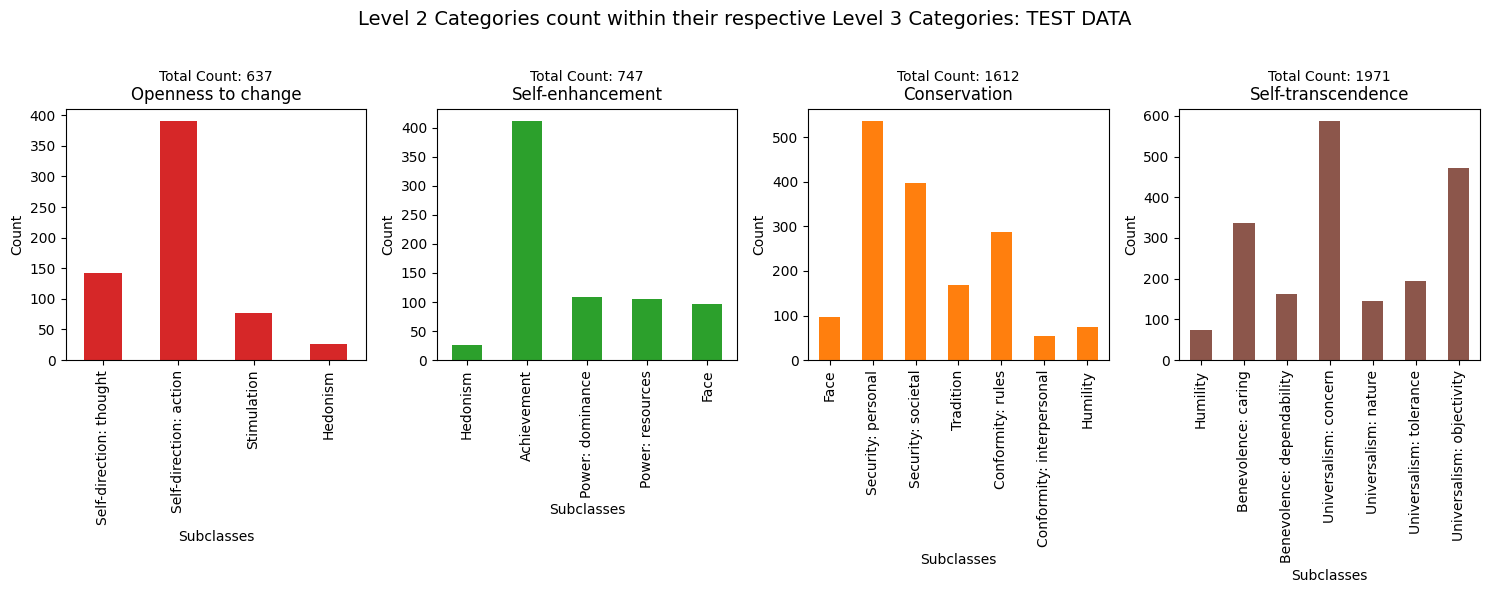

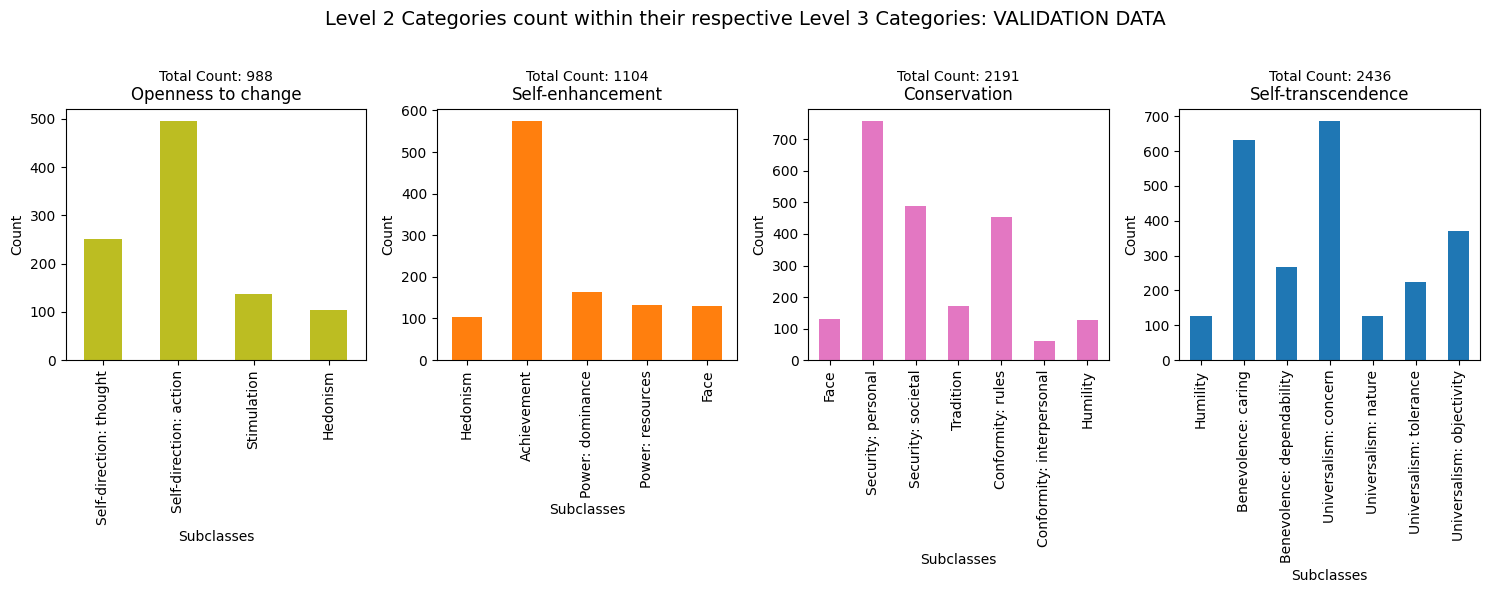

In [17]:
def plot_l2_to_l3_count(df:pd.DataFrame, title):
    '''Plot the histogram of the labels'''
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15,6 ))
    colors = random.sample(list(mcolors.TABLEAU_COLORS.keys()), 4)
    
    for i, (label, subclasses) in enumerate(level2_to_level3.items()):
        ax = axes[i]
        df[subclasses].eq(1).sum().plot(kind='bar', ax=ax, color=colors[i])
        ax.set_title(f'{label}')
        ax.set_xlabel('Subclasses')
        ax.set_ylabel('Count')
        total_count = df[subclasses].eq(1).sum().sum() 
        ax.text(0.5, 1.11, f'Total Count: {total_count}', transform=ax.transAxes, ha='center')  
        
    plt.suptitle(f"Level 2 Categories count within their respective Level 3 Categories: {str.upper(title)} DATA",fontsize=14)
    plt.tight_layout()
    plt.show()

plot_l2_to_l3_count(l2_train_df, "Training")
plot_l2_to_l3_count(l2_test_df, "Test")
plot_l2_to_l3_count(l2_valid_df, "Validation")

    

In [18]:
l2_train_df.describe()


,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,Power: resources,Face,Security: personal,Security: societal,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
count,5393.000000,5393.000000,5393.000000,5393.000000,5393.000000,5393.000000,5393.000000,5393.000000,5393.000000,5393.000000,5393.000000,5393.000000,5393.000000,5393.000000,5393.000000,5393.000000,5393.000000,5393.000000,5393.000000,5393.000000
mean,0.183200,0.258669,0.045800,0.031893,0.280363,0.113110,0.115891,0.070833,0.370851,0.320415,0.105322,0.218246,0.038383,0.073243,0.246987,0.149453,0.385871,0.079177,0.123123,0.195439
std,0.386867,0.437944,0.209071,0.175732,0.449218,0.316756,0.320124,0.256569,0.483077,0.466679,0.306996,0.413094,0.192137,0.260559,0.431299,0.356567,0.486845,0.270039,0.328608,0.396575
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
def get_level3_labels_df(df,labels_df):
    label3_df = labels_df[['Argument ID']].copy()
    
    for label3, labels2 in level2_to_level3.items():
        start_label = labels2[0]
        end_label = labels2[-1] 
        label3_df[label3] = (labels_df.loc[:,start_label:end_label].sum(axis=1) > 0).astype(int)
        
    l3_df = pd.merge(df, label3_df, on='Argument ID')

    return l3_df

train_df = get_level3_labels_df(train_data,train_labels)
test_df = get_level3_labels_df(test_data,test_labels)
valid_df = get_level3_labels_df(valid_data,valid_labels)
train_df.head()


,Argument ID,Conclusion,Stance,Premise,Openness to change,Self-enhancement,Conservation,Self-transcendence
0,A01002,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...,0,0,1,0
1,A01005,We should ban fast food,in favor of,fast food should be banned because it is reall...,0,0,1,0
2,A01006,We should end the use of economic sanctions,against,sometimes economic sanctions are the only thin...,0,1,1,0
3,A01007,We should abolish capital punishment,against,capital punishment is sometimes the only optio...,0,0,1,1
4,A01008,We should ban factory farming,against,factory farming allows for the production of c...,0,0,1,1


In [20]:
train_df.shape

(5393, 8)

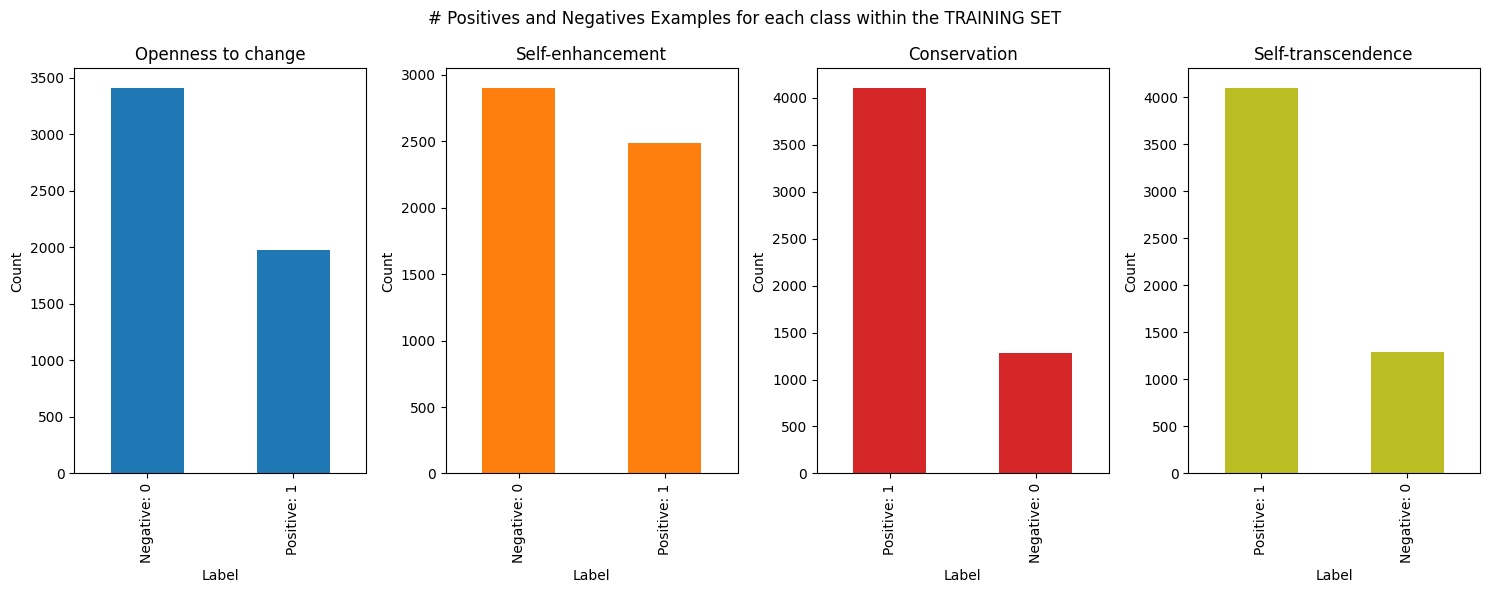

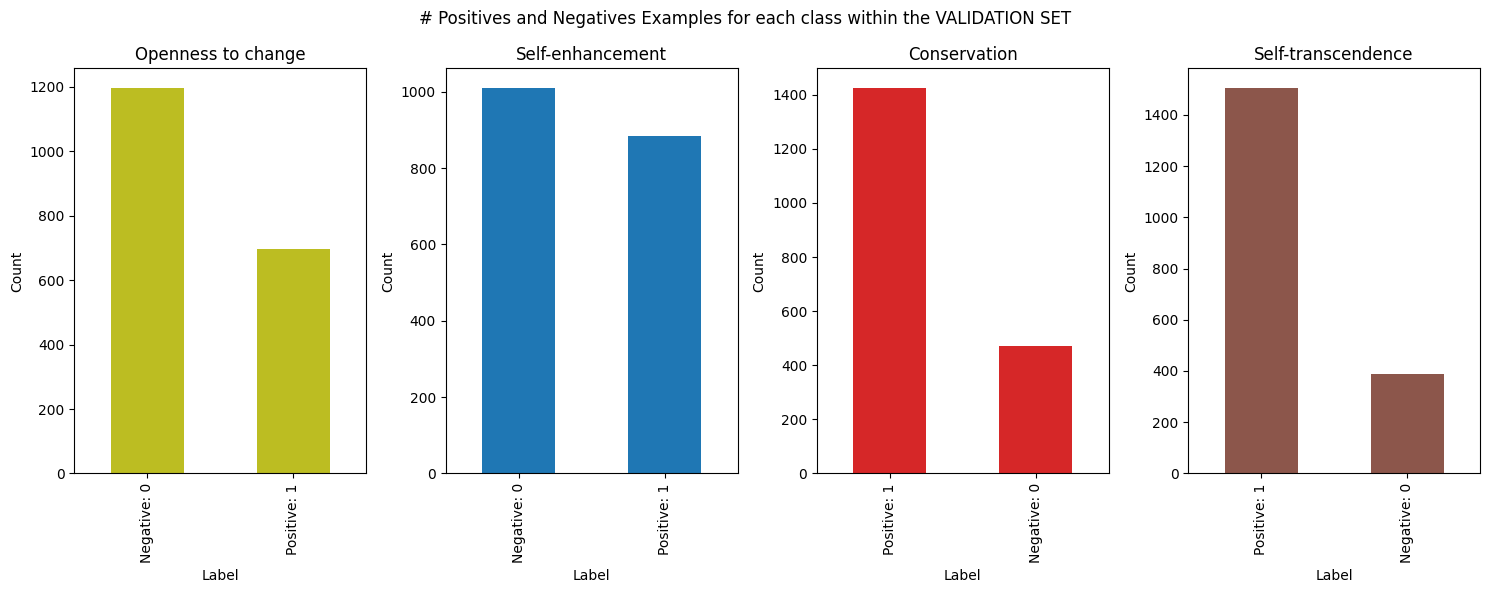

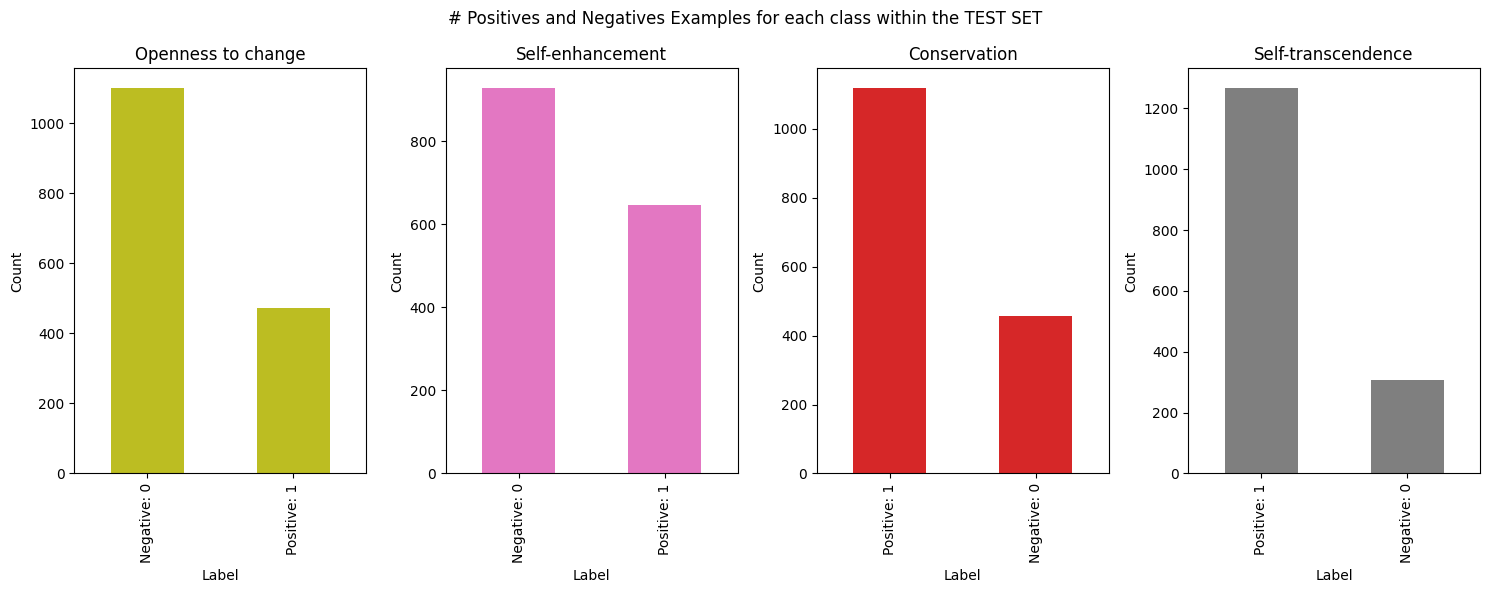

In [21]:
def plot_label_count(df: pd.DataFrame, title:str):
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 6))
    colors = random.sample(list(mcolors.TABLEAU_COLORS.keys()), 4)
    labels = list(level2_to_level3.keys())


    for i,label in enumerate(labels):
        ax = axes[i]
        count_labels = df[label].replace({0: 'Negative: 0', 1: 'Positive: 1'}).value_counts()
        count_labels.plot(kind='bar', ax=ax, color=colors[i], label=label)
        ax.set_title(f'{label}')
        ax.set_xlabel('Label')
        ax.set_ylabel('Count')
        
    plt.suptitle(f'# Positives and Negatives Examples for each class within the {str.upper(title)} SET', fontsize=12)
    plt.tight_layout()
    plt.show()

plot_label_count(train_df,"training")
plot_label_count(valid_df,"Validation")
plot_label_count(test_df,"Test")

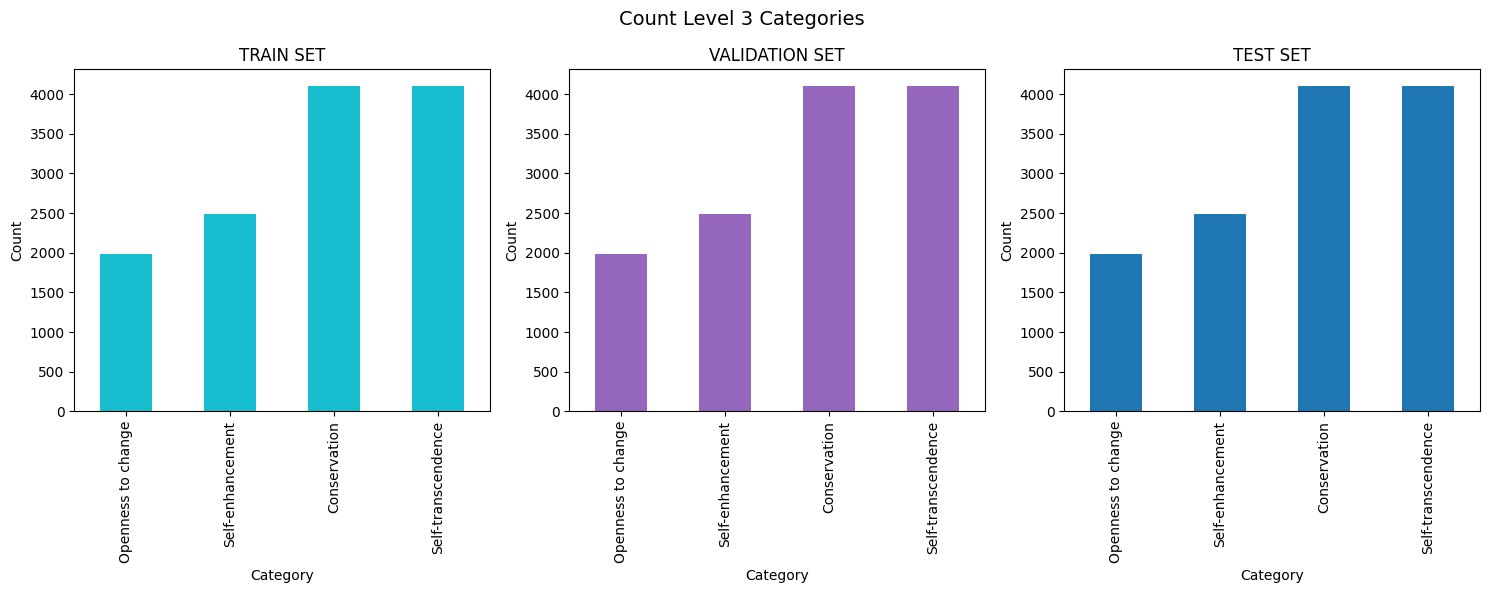

In [22]:

def plot_samples_per_class(df_train, df_valid, df_test):

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
    axes = axes.flatten()
    colors = random.sample(list(mcolors.TABLEAU_COLORS.keys()), 4)
    labels = list(level2_to_level3.keys())

    for i in range(3):
        ax = axes[i]
        train_counts = df_train[labels].eq(1).sum()
        valid_counts = df_valid[labels].eq(1).sum()
        test_counts = df_test[labels].eq(1).sum()
        
        train_counts.plot(kind='bar', ax=ax, color=colors[i])
        valid_counts.plot(kind='bar', ax=ax, color=colors[i])
        test_counts.plot(kind='bar', ax=ax, color=colors[i])
        ax.set_title(f'{["TRAIN SET", "VALIDATION SET", "TEST SET"][i]}')
        ax.set_xlabel('Category')
        ax.set_ylabel('Count')
        ax.set_xticklabels(labels)

        
    plt.suptitle('Count Level 3 Categories ', fontsize=14)
    plt.tight_layout()
    plt.show()


plot_samples_per_class(train_df,valid_df,test_df)

In [23]:
train_df.describe()

,Openness to change,Self-enhancement,Conservation,Self-transcendence
count,5393.000000,5393.000000,5393.000000,5393.000000
mean,0.366957,0.461524,0.761543,0.761172
std,0.482019,0.498564,0.426180,0.426407
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,1.000000
50%,0.000000,0.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000


### Maybe these analyses don't make much sense.

In [24]:
correlation_matrix = train_df[['Openness to change', 'Self-enhancement', 'Conservation', 'Self-transcendence']].corr()
print(correlation_matrix)


                    Openness to change  Self-enhancement  Conservation  \
Openness to change            1.000000          0.115484     -0.189673   
Self-enhancement              0.115484          1.000000     -0.043188   
Conservation                 -0.189673         -0.043188      1.000000   
Self-transcendence           -0.134770         -0.064169      0.018234   

                    Self-transcendence  
Openness to change           -0.134770  
Self-enhancement             -0.064169  
Conservation                  0.018234  
Self-transcendence            1.000000  


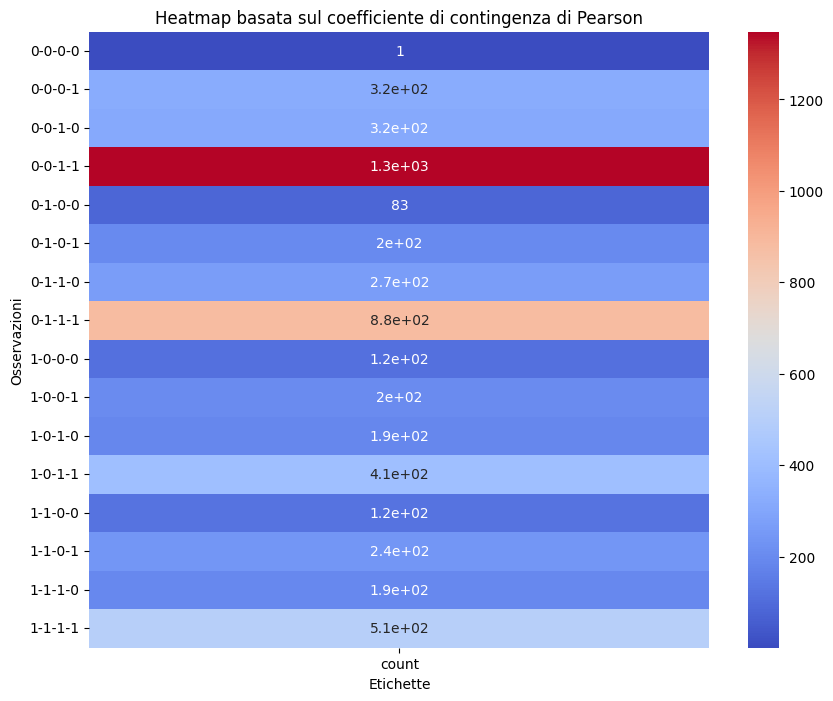

In [25]:

contingency_table = pd.crosstab(index=[train_df['Openness to change'],train_df['Self-enhancement'],train_df['Conservation'], train_df['Self-transcendence']], columns='count')

plt.figure(figsize=(10, 8))
sns.heatmap(contingency_table, annot=True, cmap="coolwarm")
plt.title('Heatmap basata sul coefficiente di contingenza di Pearson')
plt.xlabel('Etichette')
plt.ylabel('Osservazioni')
plt.show()

# 2 Models Definition

### BASELINE MODELS

In [26]:
def compute_labels_prob_distribution(df,title):
    print(f"{str.upper(title)} SET:\n")
    for i in df.columns[4:]:
        print(f"Probability distribution of {i} \n{df[i].value_counts(normalize=True).round(2)}")
        print("\n")
        
        
compute_labels_prob_distribution(train_df,"train")

TRAIN SET:

Probability distribution of Openness to change 
Openness to change
0    0.63
1    0.37
Name: proportion, dtype: float64


Probability distribution of Self-enhancement 
Self-enhancement
0    0.54
1    0.46
Name: proportion, dtype: float64


Probability distribution of Conservation 
Conservation
1    0.76
0    0.24
Name: proportion, dtype: float64


Probability distribution of Self-transcendence 
Self-transcendence
1    0.76
0    0.24
Name: proportion, dtype: float64




TRAIN SET:



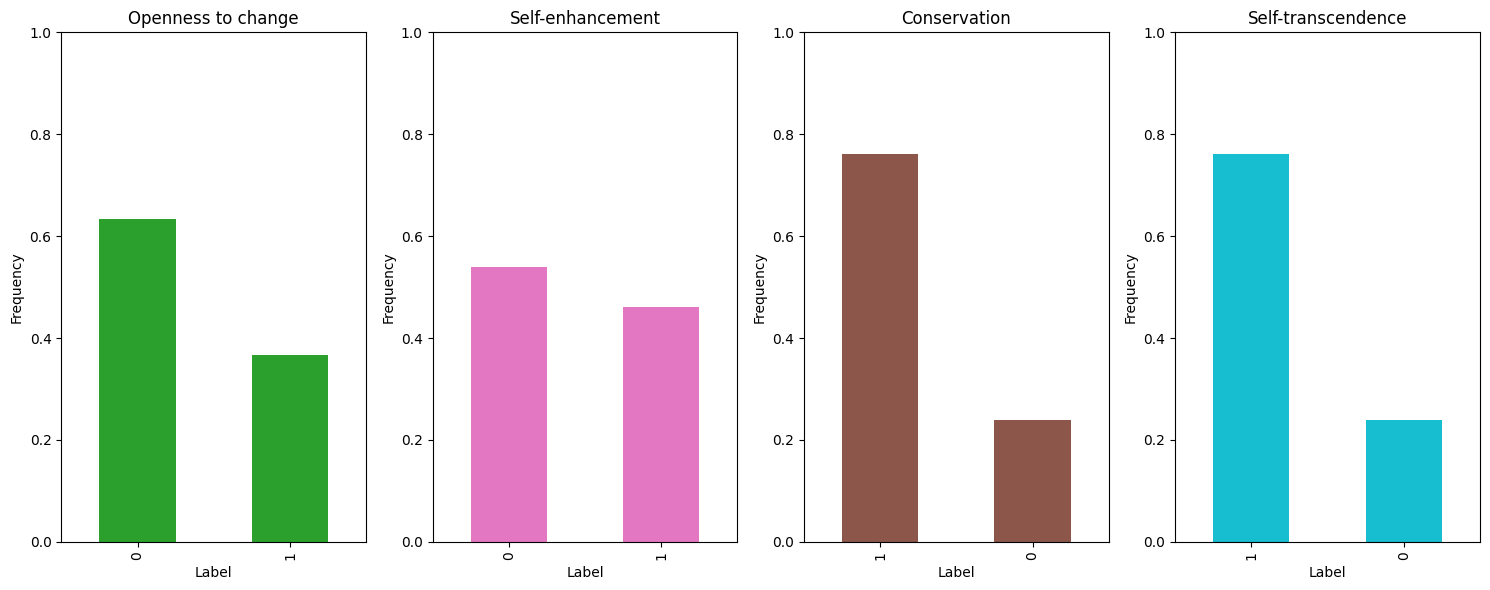

VALIDATION SET:



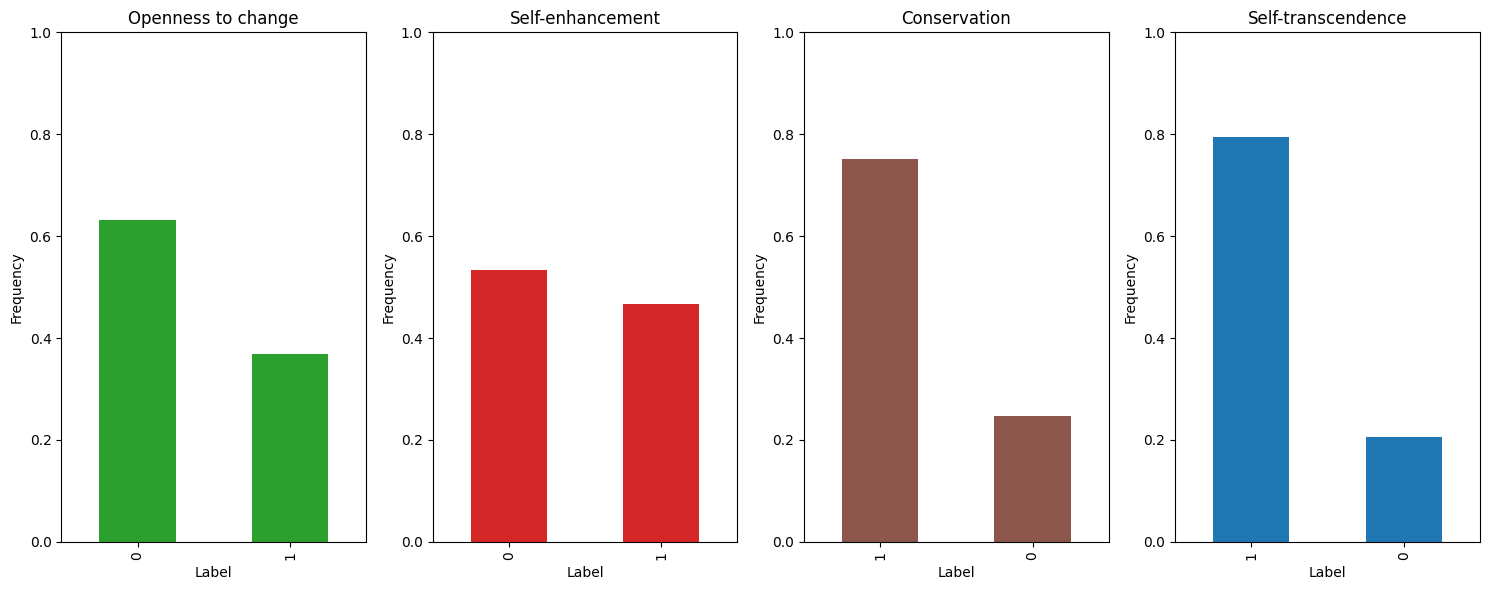

TEST SET:



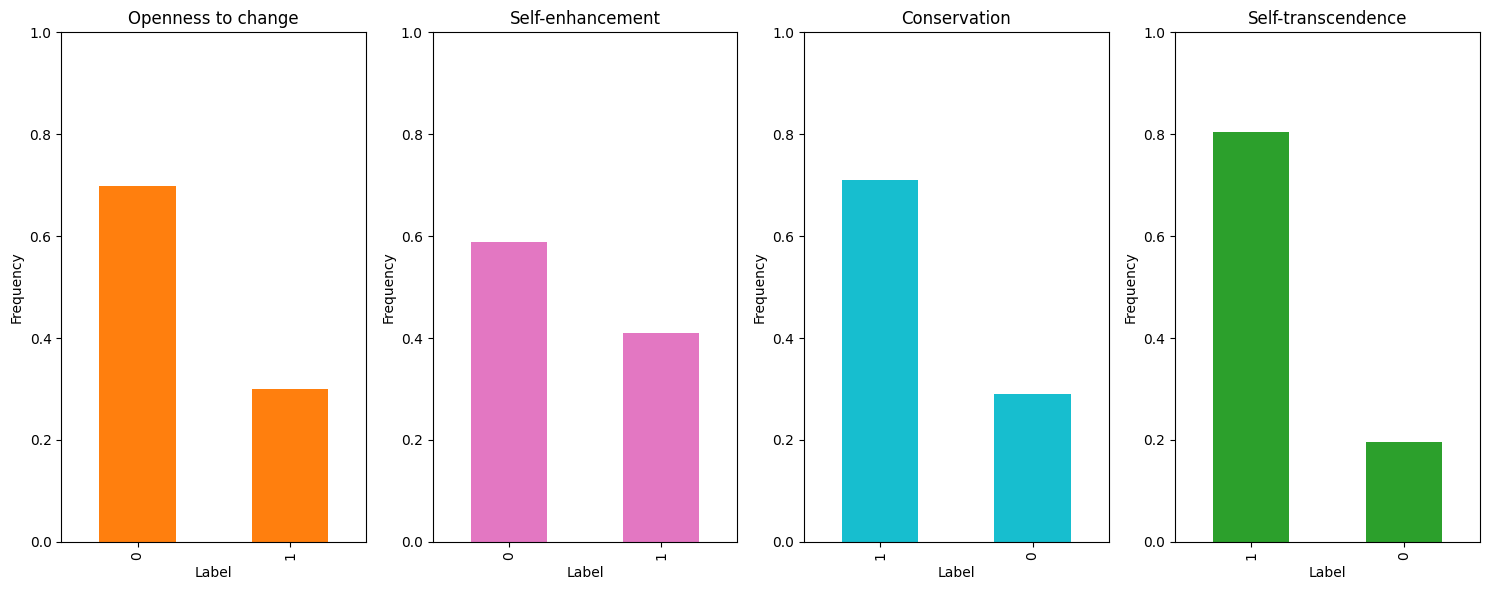

In [27]:

def plot_probability_distribution(dataframe, title):
    print(f"{str.upper(title)} SET:\n")
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 6))
    colors = random.sample(list(mcolors.TABLEAU_COLORS.keys()), 4)
    for i in range(4):
        ax = axes[i]
        for column in dataframe.columns[4:]:
            dataframe[dataframe.columns[i+4]].value_counts(normalize=True).plot(kind='bar', ax=ax, color=colors[i])
            ax.set_title(f'{dataframe.columns[i+4]}')
            ax.set_xlabel('Label')
            ax.set_ylabel('Frequency')
            ax.set_ylim(0, 1)
    
    
    plt.tight_layout()
    plt.show()

plot_probability_distribution(train_df, "train")
plot_probability_distribution(valid_df, "validation")
plot_probability_distribution(test_df, "test")

## Exploring Sentences

In [28]:
train_df.head()

,Argument ID,Conclusion,Stance,Premise,Openness to change,Self-enhancement,Conservation,Self-transcendence
0,A01002,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...,0,0,1,0
1,A01005,We should ban fast food,in favor of,fast food should be banned because it is reall...,0,0,1,0
2,A01006,We should end the use of economic sanctions,against,sometimes economic sanctions are the only thin...,0,1,1,0
3,A01007,We should abolish capital punishment,against,capital punishment is sometimes the only optio...,0,0,1,1
4,A01008,We should ban factory farming,against,factory farming allows for the production of c...,0,0,1,1


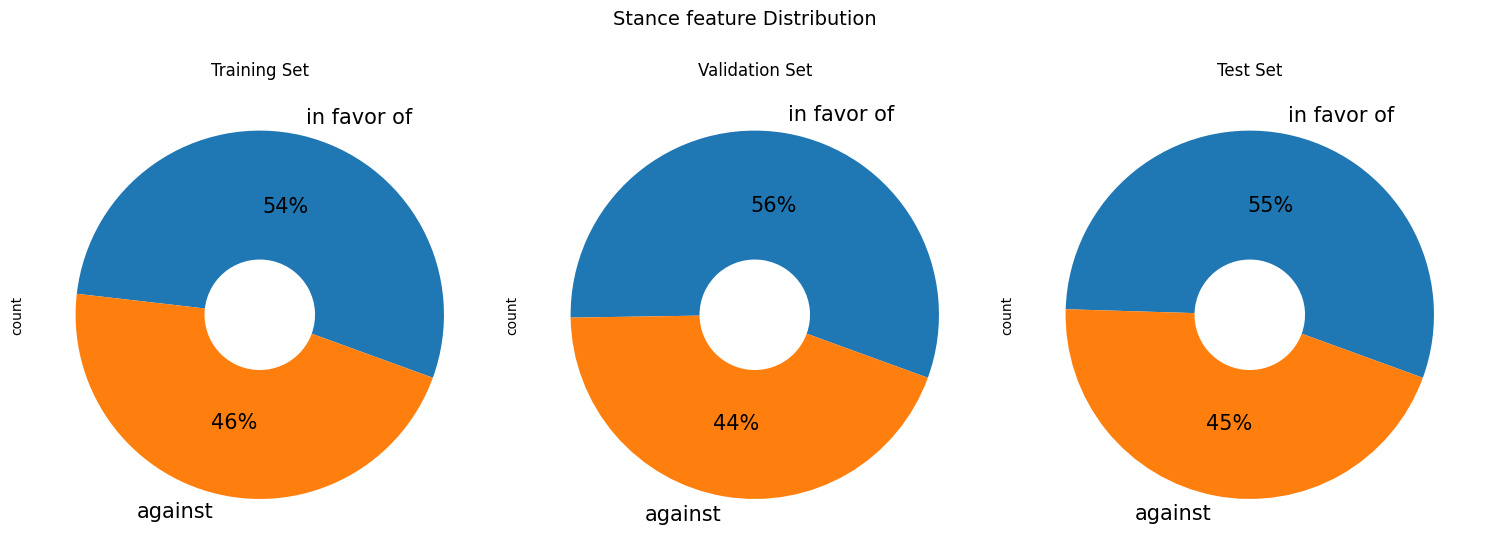

In [29]:
def plot_stance_distribution(train_df,valid_df,test_df):

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
    
    train_df["Stance"].value_counts().plot(kind='pie', labels=['in favor of', 'against'],
                                    wedgeprops=dict(width=.7), autopct='%1.0f%%', startangle= -20, 
                                    textprops={'fontsize': 15}, ax=ax[0])
    ax[0].set_title('Training Set')
    valid_df["Stance"].value_counts().plot(kind='pie', labels=['in favor of', 'against'],
                                    wedgeprops=dict(width=.7), autopct='%1.0f%%', startangle= -20, 
                                    textprops={'fontsize': 15}, ax=ax[1])
    ax[1].set_title('Validation Set')
    test_df["Stance"].value_counts().plot(kind='pie', labels=['in favor of', 'against'],
                                    wedgeprops=dict(width=.7), autopct='%1.0f%%', startangle= -20, 
                                    textprops={'fontsize': 15}, ax=ax[2])
    ax[2].set_title('Test Set')
    

    plt.suptitle('Stance feature Distribution', fontsize=14)
    plt.tight_layout()
    plt.show()

plot_stance_distribution(train_df,valid_df,test_df)

In [15]:
def refine_df(df):
    new_df = df.copy()
    new_df["Stance"] = df['Stance'].replace({'in favor of': 1, 'against': 0})
    new_df.drop(df.columns[4:], axis=1, inplace=True)
    new_df['Label'] = df.iloc[:, 4:].apply(lambda x: list(x), axis=1) 
    return new_df

train_dataframe = refine_df(train_df)
test_dataframe = refine_df(test_df)
valid_dataframe = refine_df(valid_df)


In [31]:
display(train_dataframe.head())

,Argument ID,Conclusion,Stance,Premise,Label
0,A01002,We should ban human cloning,1,we should ban human cloning as it will only ca...,"[0, 0, 1, 0]"
1,A01005,We should ban fast food,1,fast food should be banned because it is reall...,"[0, 0, 1, 0]"
2,A01006,We should end the use of economic sanctions,0,sometimes economic sanctions are the only thin...,"[0, 1, 1, 0]"
3,A01007,We should abolish capital punishment,0,capital punishment is sometimes the only optio...,"[0, 0, 1, 1]"
4,A01008,We should ban factory farming,0,factory farming allows for the production of c...,"[0, 0, 1, 1]"


In [32]:
train_df["Premise"].describe()

count                     5393
unique                    5313
top       Migrants sell drugs.
freq                         2
Name: Premise, dtype: object

In [33]:

train_df["Conclusion"].describe()

count                                         5393
unique                                         332
top       We should abolish the three-strikes laws
freq                                           114
Name: Conclusion, dtype: object

In [16]:
def compute_text_lengths(train_df: pd.DataFrame, test_df:pd.DataFrame, valid_df:pd.DataFrame):
    lengths = dict()

    for i in ['Premise', 'Conclusion']:
        lengths[i] = {
            'Training': {
                'Max Length': train_df[i].apply(len).max(),
                'Min Length': train_df[i].apply(len).min(),
                'Mean Length': train_df[i].apply(len).mean().round(2)
            },
            'Test': {
                'Max Length': test_df[i].apply(len).max(),
                'Min Length': test_df[i].apply(len).min(),
                'Mean Length': test_df[i].apply(len).mean().round(2)
            },
            'Validation': {
                'Max Length': valid_df[i].apply(len).max(),
                'Min Length': valid_df[i].apply(len).min(),
                'Mean Length': valid_df[i].apply(len).mean().round(2)
            }
        }
    
    return lengths

for i in compute_text_lengths(train_dataframe, test_dataframe, valid_dataframe).items():
    print(f"{i[0]} Feature:")
    print(f"\tTraining Set: \n\t\tMax Length: {i[1]['Training']['Max Length']}, \n\t\tMin Length: {i[1]['Training']['Min Length']}, \n\t\tMean Length: {i[1]['Training']['Mean Length']}")
    print(f"\tValidation Set: \n\t\tMax Length: {i[1]['Validation']['Max Length']}, \n\t\tMin Length: {i[1]['Validation']['Min Length']}, \n\t\tMean Length: {i[1]['Validation']['Mean Length']}")
    print(f"\tTest Set: \n\t\tMax Length: {i[1]['Test']['Max Length']}, \n\t\tMin Length: {i[1]['Test']['Min Length']}, \n\t\tMean Length: {i[1]['Test']['Mean Length']}")
    print("\n")

Premise Feature:
	Training Set: 
		Max Length: 792, 
		Min Length: 20, 
		Mean Length: 128.85
	Validation Set: 
		Max Length: 825, 
		Min Length: 35, 
		Mean Length: 130.9
	Test Set: 
		Max Length: 822, 
		Min Length: 35, 
		Mean Length: 128.79


Conclusion Feature:
	Training Set: 
		Max Length: 190, 
		Min Length: 21, 
		Mean Length: 39.71
	Validation Set: 
		Max Length: 184, 
		Min Length: 23, 
		Mean Length: 41.05
	Test Set: 
		Max Length: 157, 
		Min Length: 18, 
		Mean Length: 36.06




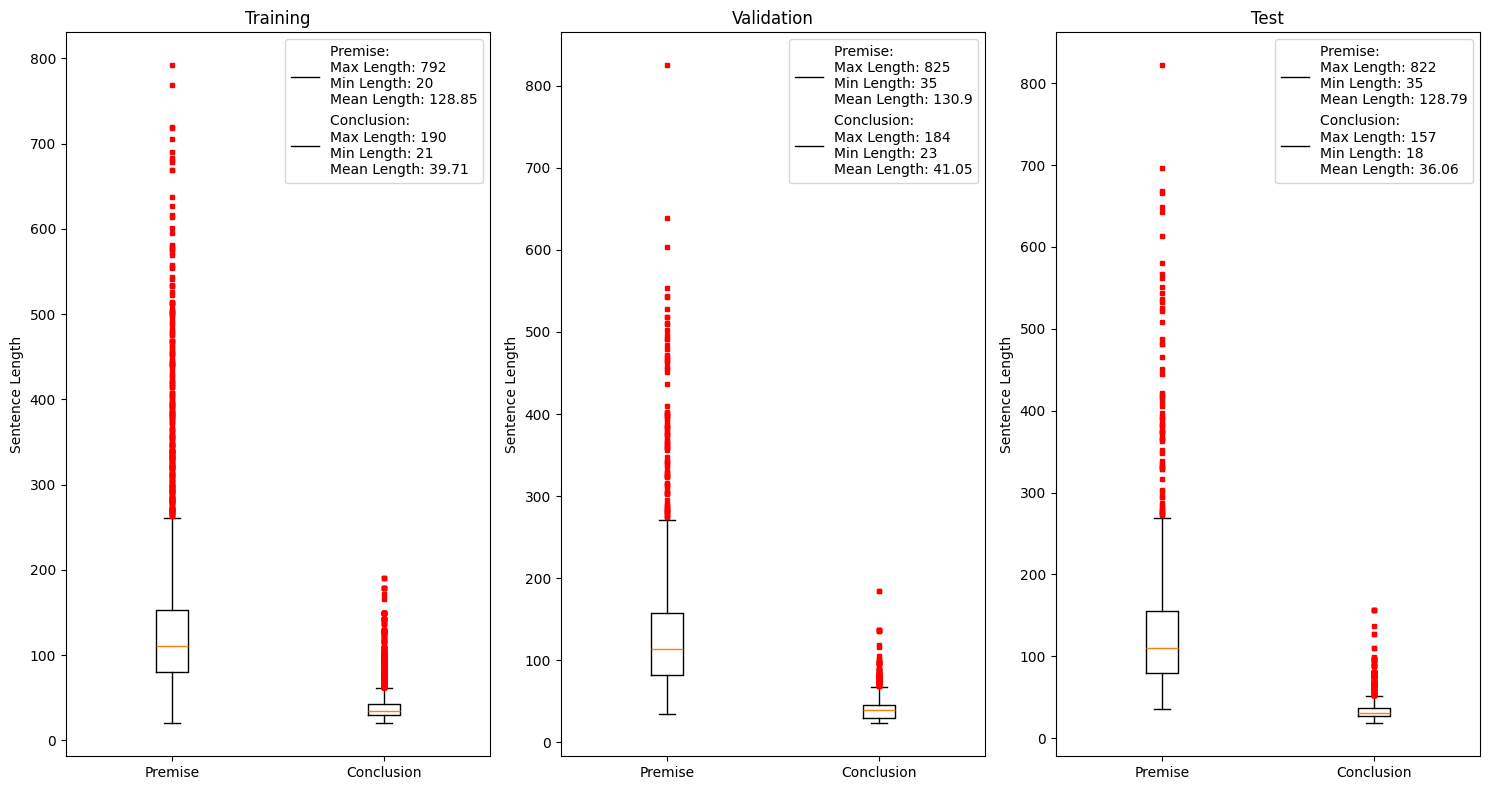

In [35]:
def plot_sentence_lengths(train: pd.DataFrame, test_df:pd.DataFrame, valid_df:pd.DataFrame):
    features = ['Premise', 'Conclusion']
    train_lengths = train_df[features].apply(lambda x: x.str.len())
    valid_lengths = valid_df[features].apply(lambda x: x.str.len())
    test_lengths = test_df[features].apply(lambda x: x.str.len())

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 8))
    labels = ['Training', 'Validation', 'Test']
    data = [train_lengths, valid_lengths, test_lengths]
    flierprops = dict(marker='s', markerfacecolor='r', markersize=3,
                  linestyle='none', markeredgecolor='r')
    

    for i, ax in enumerate(axes):
        ax.boxplot(data[i].values,flierprops=flierprops)
        ax.set_xticklabels(['Premise', 'Conclusion'])
        ax.set_title(labels[i])
        ax.set_ylabel('Sentence Length')
            
        text_lengths = compute_text_lengths(train_df, test_df, valid_df)
        legend_premise_text = f"{features[0]}: \nMax Length: {text_lengths[features[0]][labels[i]]['Max Length']}\nMin Length: {text_lengths[features[0]][labels[i]]['Min Length']}\nMean Length: {text_lengths[features[0]][labels[i]]['Mean Length']}"
        legend__conclusion_text = f"{features[1]}: \nMax Length: {text_lengths[features[1]][labels[i]]['Max Length']}\nMin Length: {text_lengths[features[1]][labels[i]]['Min Length']}\nMean Length: {text_lengths[features[1]][labels[i]]['Mean Length']}"
        ax.legend([legend_premise_text,legend__conclusion_text], loc='upper right',ncol=1)

    plt.tight_layout()
    plt.show()

plot_sentence_lengths(train_dataframe,test_dataframe,valid_dataframe)

p(y_hat = y) = p(y_hat = 0) * p(y = 0) + p(y_hat = 1) * p(y = 1)

p(y_hat = Openess_to_change) = 0.5 * 0.63 + 0.5 * 0.37 = 0.315 + 0.185 = 0.5  
p(y_hat = Self-enhancement) = 0.5 * 0.54 + 0.5 * 0.46 = 0.27 + 0.23 = 0.5      
p(y_hat = Conservation) = 0.5 * 0.24 + 0.5 * 0.0.76 = 0.12 + 0.38 = 0.5          
p(y_hat = Self-trascendence) = 0.5 * 0.24 + 0.5 * 0.0.76 = 0.12 + 0.38 = 0.5

mean = 0.5


In [36]:
#Random Unifor Classifier

num_samples = len(train_df)
num_classes = 4

random_predictions = np.random.randint(2, size=(num_samples, num_classes))  

num_zeros = np.count_nonzero(random_predictions == 0)
num_ones = np.count_nonzero(random_predictions == 1)
print("Number of 0s:", num_zeros)
print("Number of 1s:", num_ones)

true_labels = train_df.iloc[:, 4:].values  


accuracy = np.mean(np.equal(random_predictions, true_labels))
print("Accuracy: {:.2f}".format(accuracy))


Number of 0s: 10780
Number of 1s: 10792
Accuracy: 0.50


p(yhat = y) = P(yhat = 0) * P(y = 0) + P(yhat = 1) * P(y = 1) 

p(y_hat = Openess_to_change) = 1 * 0.63 + 0 * 0.37 = 0.63      
p(y_hat = Self-enhancement) = 1 * 0.54 + 0 * 0.46 =  0.54      
p(y_hat = Conservation) =  0 * 0.24 + 1 * 0.76 = 0.76          
p(y_hat = Self-trascendence) = 0 * 0.24 + 1 * 0.76 = 0.76      

mean = 0.63 + 0.54 + 0.76 + 0.76 / 4 = ~ 0.67


In [37]:
#Majoirty Classifier

true_labels = train_df.iloc[:, 4:].values


num_zeros = np.sum(true_labels == 0, axis=0)
num_ones = np.sum(true_labels == 1, axis=0)
print("Number of 0s:", num_zeros)
print("Number of 1s:", num_ones)

majority_predictions = np.where(num_zeros > num_ones, 0, 1)
print("Majority Predictions:", majority_predictions.shape)


accuracy = np.mean(np.equal(majority_predictions, true_labels))
print("Majority Classifier Accuracy: {:.2f}".format(accuracy))

Number of 0s: [3414 2904 1286 1288]
Number of 1s: [1979 2489 4107 4105]
Majority Predictions: (4,)
Majority Classifier Accuracy: 0.67


## Dataset 

In [17]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
def SentimentDatsetMapFunction(conclusion_encodings, premise_encodings, stances, labels):
    inputs = {
        'conclusion': conclusion_encodings,
        'premise': premise_encodings,
        'stance': stances
    }
    return inputs, labels

def make_dataset(df,max_length,tokenizer,batch_size):
    conclusion_encodings = tokenizer(list(df["Conclusion"]), truncation=True, padding="max_length", max_length=max_length)
    premise_encodings = tokenizer(list(df["Premise"]), truncation=True, padding="max_length", max_length=max_length)
    labels = tf.constant(list(df["Label"]), dtype=tf.float32)
    stances = tf.constant(list(df["Stance"]), dtype=tf.float32)

    # Convert BatchEncoding to tensors
    conclusion_encodings = {key: tf.constant(val) for key, val in conclusion_encodings.items()}
    premise_encodings = {key: tf.constant(val) for key, val in premise_encodings.items()}
    
    dataset = tf.data.Dataset.from_tensor_slices((conclusion_encodings,premise_encodings, stances, labels))
    dataset = dataset.batch(batch_size,drop_remainder=True)
    dataset = dataset.map(SentimentDatsetMapFunction)
    return dataset.shuffle(5393).prefetch(16).cache() 

In [ ]:
lengths = compute_text_lengths(train_dataframe, test_dataframe, valid_dataframe)

train_max_length_c = round(lengths['Conclusion']['Training']['Mean Length'])
valid_max_length_c = round(lengths['Conclusion']['Validation']['Mean Length'])
test_max_length_c = round(lengths['Conclusion']['Test']['Mean Length'])

max_length_c = int((train_max_length_c + valid_max_length_c + test_max_length_c) / 3)

#train_dataset = make_dataset(train_dataframe, train_max_length_c, tokenizer, batch_size=32)
#test_dataset = make_dataset(test_dataframe, test_max_length_c, tokenizer,  batch_size=32)
#valid_dataset = make_dataset(valid_dataframe, valid_max_length_c, tokenizer,  batch_size=32)
train_dataset = make_dataset(train_dataframe, max_length_c, tokenizer, batch_size=32)
test_dataset = make_dataset(test_dataframe, max_length_c, tokenizer,  batch_size=32)
valid_dataset = make_dataset(valid_dataframe, max_length_c, tokenizer,  batch_size=32)

In [ ]:
print(train_dataset)
print(train_dataset.take(1))
first_element = next(iter(train_dataset.take(1)))
print(first_element)

In [ ]:
#check tokens
def check_tokens(tokenizer):
    # Get the special tokens and their corresponding IDs
    special_tokens = tokenizer.special_tokens_map
    special_ids = tokenizer.convert_tokens_to_ids(list(special_tokens.values()))
    print("Special tokens:")
    for token_type, token_list in special_tokens.items():
        print(f"{token_type}: {token_list}")
    # Print the special tokens and their corresponding IDs
    for token, id in zip(special_tokens.keys(), special_ids):
        print(f"{token}: {id}")


assert isinstance(tokenizer, PreTrainedTokenizerFast)

# Setting the BOS and EOS token
#tokenizer_M1.bos_token = tokenizer_M1.cls_token
#tokenizer_M1.eos_token = tokenizer_M1.sep_token
check_tokens(tokenizer)

In [ ]:
#checks inputs_features
def get_input_features(inputs, text_feature:str): 
        
        input_ids = inputs[text_feature]['input_ids']
        attention_mask = inputs[text_feature]['attention_mask']
        token_type_ids = inputs[text_feature]['token_type_ids']

        return input_ids, attention_mask, token_type_ids

for inputs,_ in train_dataset:   #inputs it's a tuple with a dictionary of tensors, labels is a tensor
        conclusion_input_ids, conclusion_attention_mask, conclusion_token_type_ids = get_input_features(inputs, 'conclusion')
        print(conclusion_input_ids)
        break

In [ ]:
def retrieve_conclusion_premise(dataset):
    for features, _ in dataset.take(1):  
        for i in ["conclusion","premise"]:
            input_ids = features[i]["input_ids"].numpy()[:128]  
            decoded = tokenizer.decode(input_ids)
            print(f"{str.upper(i)} tokens:", decoded)
            print("\n")
            
retrieve_conclusion_premise(train_dataset)

#### define f1_score

In [1]:
#1:
import tensorflow as tf
from sklearn.metrics import f1_score

def f1_macro(labels, predictions, threshold=0.5):
    """
    Computes the F1 macro score for binary predictions based on a given threshold.

    @param labels (array-like): Ground truth labels (true binary values: 0 or 1).
    @param  predictions (array-like): Predicted probabilities or scores.
    @param threshold (float, optional): Threshold for converting probabilities to binary predictions.
                                        Default to 0.5.

    return float: F1 macro score, a measure of the model's performance on binary classification.

    """

    binary_predictions = tf.cast(predictions > threshold, tf.int32)
    f1_macro = f1_score(y_true=labels, y_pred=binary_predictions, average='macro')
    return f1_macro

In [ ]:
#2
'''
def per_category_f1(y_true, y_pred):
    """
    Compute per-category binary F1-score.

    Parameters:
        y_true (tensorflow.Tensor): True labels.
        y_pred (tensorflow.Tensor): Predicted labels.

    Returns:
        per_category_f1_scores (dict): Dictionary containing per-category F1-scores.
    """
    per_category_f1_scores = {}
    categories = tf.unique(tf.reshape(y_true, [-1])).y.numpy()

    for category in categories:
        category_indices = tf.where(tf.equal(y_true, category))
        category_true = tf.gather(y_true, category_indices)
        category_pred = tf.gather(y_pred, category_indices)
        f1 = f1_score(category_true, category_pred)
        per_category_f1_scores[category] = f1

    return per_category_f1_scores


def macro_f1(y_true, y_pred):
    """
    Compute macro F1-score.

    Parameters:
        y_true (numpy.ndarray): True labels.
        y_pred (numpy.ndarray): Predicted labels.

    Returns:
        macro_f1_score (float): Macro F1-score.
    """
    per_category_f1_scores = per_category_f1(y_true, y_pred)
    macro_f1_score = np.mean(list(per_category_f1_scores.values()))
    return macro_f1_score
'''

In [ ]:
#3
import tensorflow as tf
import numpy as np

def per_category_f1(y_true, y_pred):
    per_category_f1_scores = {}
    categories = tf.unique(tf.reshape(y_true, [-1])).y.numpy()

    for category in categories:
        category_indices = tf.where(tf.equal(y_true, category))
        category_true = tf.gather(y_true, category_indices)
        category_pred = tf.gather(y_pred, category_indices)
        f1 = f1_score(category_true, category_pred)
        per_category_f1_scores[category] = f1

    return per_category_f1_scores

def macro_f1(y_true, y_pred):
    per_category_f1_scores = per_category_f1(y_true, y_pred)
    macro_f1_score = np.mean(list(per_category_f1_scores.values()))
    return macro_f1_score

# Compile the code
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[macro_f1])


### Instantiate the models

## 1st way: Suclassing model and use fit

In [18]:
class RandomClassifier(keras.Model):
    def __init__(self, num_classes):
        super(RandomClassifier, self).__init__()
        self.num_classes = num_classes
        

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        random_predictions = tf.random.uniform(shape=(batch_size, self.num_classes), minval=0, maxval=2, dtype=tf.int32)
        return random_predictions



class MajorityClassifier(tf.keras.Model):
    def __init__(self, num_categories):
        super(MajorityClassifier, self).__init__()
        self.num_categories = num_categories
        self.majority_classes = tf.Variable(np.zeros(num_categories), trainable=False, dtype=tf.int32)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        return tf.repeat(tf.expand_dims(self.majority_classes, 0), repeats=batch_size, axis=0)

    def fit(self, x, y):
        labels = y
        threshold = len(labels) / 2
        is_majority = tf.reduce_sum(labels, axis=0) > threshold
        self.majority_classes.assign(tf.cast(is_majority, tf.int32))


In [101]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dropout, Dense, Concatenate

class MultilabelClassifier(tf.keras.Model):
    def __init__(self, num_labels, drop_out: int = 0.1, model_type: str = "base"):
        super(MultilabelClassifier, self).__init__()
        self.num_labels = num_labels
        self.model_type = model_type
        
        self.bert_conclusion = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels,name="bert_conclusion")

        if model_type != "base":
          self.bert_premise = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels,name="bert_conclusion_premise")

        if model_type == "bert_w_cp":
          self.hidden_dim = self.bert_conclusion.config.hidden_size * 2

        elif model_type == "bert_w_cps":
          self.hidden_dim = (self.bert_conclusion.config.hidden_size * 2) + 1

        else:
          self.hidden_dim = self.bert_conclusion.config.hidden_size

        
        self.dropout = tf.keras.layers.Dropout(drop_out)
        self.dense = tf.keras.layers.Dense(num_labels, activation='sigmoid')
    
    def call(self, inputs):
        
         # Extracting data for conclusion
        ids_c = inputs['conclusion']['input_ids']
        mask_c = inputs['conclusion']['attention_mask']
        token_type_ids_c = inputs['conclusion']['token_type_ids']


        # Extracting data for premise
        ids_p =inputs['premise']['input_ids']
        mask_p = inputs['premise']['attention_mask']
        token_type_ids_p = inputs['premise']['token_type_ids']
        
        conclusion_outputs = self.bert_conclusion(input_ids=ids_c, attention_mask=mask_c,token_type_ids=token_type_ids_c)
        pooled_output_c = conclusion_outputs.logits
        
        if self.model_type != "base":
            ids_p, mask_p, token_type_ids_p = self.get_input_features(inputs[1], 'premise')
            premise_outputs = self.bert_premise(input_ids=ids_p, attention_mask=mask_p,token_type_ids = token_type_ids_p)
            pooled_output_cp = premise_outputs.logits
            
        if self.model_type == "bert_w_cp":
            output = Concatenate(axis=1)([pooled_output_c, pooled_output_cp])
        
        elif self.model_type == "bert_w_cps":
            stance = inputs[2]
            output = Concatenate(axis=1)([pooled_output_c, stance, pooled_output_cp])
        else:
            output = pooled_output_c

        output = self.dropout(output)
        output = self.dense(output)
        return output
    

    '''    
    def call(self, dataset,stance=None):
        
        conclusion_input_ids,conclusion_attention_mask, conclusion_token_type_ids = self.get_input_features(dataset, 'conclusion')
        
        
        conclusion_outputs = self.bert_conclusion(input_ids=conclusion_input_ids, attention_mask=conclusion_attention_mask,token_type_ids=conclusion_token_type_ids)
        pooled_output_c = conclusion_outputs.logits
        
        if self.model_type != "base":
            premise_input_ids, premise_attention_mask, premise_token_type_ids = self.get_input_features(dataset, 'premise')
            premise_outputs = self.bert_premise(input_ids=premise_input_ids, attention_mask=premise_attention_mask,token_type_ids = premise_token_type_ids)
            pooled_output_cp = premise_outputs.logits
            
            
        if self.model_type == "bert_w_cp":
            output = Concatenate(axis=1)([pooled_output_c, pooled_output_cp])
        
        elif self.model_type == "bert_w_cps":
            output = Concatenate(axis=1)([pooled_output_c, stance, pooled_output_cp])
        else:
            output = pooled_output_c

        output = self.dropout(output)
        output = self.dense(output)
        return output
    
    def get_input_features(inputs, text_feature:str): 
        
        input_ids = inputs[text_feature]['input_ids']
        attention_mask = inputs[text_feature]['attention_mask']
        token_type_ids = inputs[text_feature]['token_type_ids']

        return input_ids, attention_mask, token_type_ids
    '''
    '''  
    def get_input_features(self, dataset, text_feature:str): 
        input_ids_list = []
        token_type_ids_list = []
        attention_mask_list = []

        for input_features, _ in dataset:
            input_ids = input_features[text_feature]['input_ids']
            attention_mask = input_features[text_feature]['attention_mask']
            token_type_ids = input_features[text_feature]['token_type_ids']
            
            input_ids_list.append(input_ids)
            attention_mask_list.append(attention_mask)
            token_type_ids_list.append(token_type_ids)

        input_ids_tensor = tf.stack(input_ids_list)
        attention_mask_tensor = tf.stack(attention_mask_list)
        token_type_ids_tensor = tf.stack(token_type_ids_list)

        return input_ids_tensor, attention_mask_tensor, token_type_ids_tensor
    '''




In [2]:
import matplotlib.pyplot as plt

def plot_loss_and_metrics(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    macro_f1 = history.history['macro_f1']
    val_macro_f1 = history.history['val_macro_f1']
    epochs = range(1, len(loss) + 1)

    # Plot loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs,loss, label='Training Loss')
    plt.plot(epochs,val_loss, label='Validation Loss')
    plt.title("Training and validation Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot metrics
    plt.subplot(1, 2, 2)
    plt.plot(epochs,macro_f1, label='Training Macro F1')
    plt.plot(epochs,val_macro_f1, label='Validation Macro F1')
    plt.title('Training and validation Metrics')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [3]:
from tensorflow.keras.metrics import Precision, Recall

class MacroF1(tf.keras.metrics.Metric):
    def __init__(self, num_classes, **kwargs):
        super().__init__(**kwargs)
        self.num_classes = num_classes
        self.precisions = [Precision() for _ in range(num_classes)]
        self.recalls = [Recall() for _ in range(num_classes)]

    def update_state(self, y_true, y_pred, sample_weight=None):
        for i in range(self.num_classes):
            self.precisions[i].update_state(y_true[:, i], y_pred[:, i], sample_weight)
            self.recalls[i].update_state(y_true[:, i], y_pred[:, i], sample_weight)

    def result(self):
        f1_scores = [2 * (self.precisions[i].result() * self.recalls[i].result()) /
                     (self.precisions[i].result() + self.recalls[i].result() + tf.keras.backend.epsilon())
                     for i in range(self.num_classes)]
        return tf.reduce_mean(f1_scores)

    def reset_states(self):
        for precision, recall in zip(self.precisions, self.recalls):
            precision.reset_states()
            recall.reset_states()

NameError: name 'tf' is not defined

In [ ]:
def macro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

In [ ]:
import tensorflow as tf
import numpy as np

# Set seeds for reproducibility
#seeds = [0, 42, 121]
seeds = [0]
num_classes = 4  
model_type = "base"

for seed in seeds:
    print("-"*100)
    print(f"########################### Run with seed {seed} ########################################")

    # Hyperparameters
    N_EPOCHS = 1
    BATCH_SIZE = 32
    DROPOUT = 0.1
    LR = 1e-03


    # Set seed for reproducibility
    print(f"Setting seed for reproducibility")
    tf.random.set_seed(seed)
    np.random.seed(seed)
    print("Done")
    print()

    print("SELECTED HYPERPARAMETERS")
    hyp_str = f"run_num: {seed}  epochs: {N_EPOCHS}, batch_size: {BATCH_SIZE}, dropout: {DROPOUT},lr : {LR},"

    print(hyp_str)
    print()

    # Create model
    print("MODEL CREATION")
    model = MultilabelClassifier(num_labels = num_classes,drop_out=DROPOUT,model_type=model_type)

    # Loss and optimizer
    loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    optimizer = tf.keras.optimizers.Adam(learning_rate=LR)

    # Metrics
    macro_f1 = MacroF1(num_classes)

    # Compile model
    model.compile(optimizer=optimizer, loss=loss_function, metrics=[macro_f1])

    # Create a callback for model saving
    print("create a callback")
    print()
    checkpoint_path = f"models/model_{seed}.h5"
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_macro_f1',
        mode='max',
        save_best_only=True,
        verbose = 1)
    print("Callbacks done!")

    # Fit model
    print("START TRAINING")
    print()
    history = model.fit(train_dataset, epochs= N_EPOCHS, validation_data=valid_dataset)

    # Evaluate model
    print("Starting the evaluation ...")
    loss, f1 = model.evaluate(valid_dataset)
    print(f"Validation loss: {loss:.4f}, Macro F1: {f1:.4f}")

    # Predict
    #predictions = model.predict(valid_dataset)

    

    print("Cleaning GPU memory...")
    print()
    del model
    tf.keras.backend.clear_session()
    print("Cleaning Done!")
    

    print(f"############################## Training {seed} done. #######################################################")
    
    plot_loss_and_metrics(history)

## Training BERT Conclusion + Premise

In [ ]:
# Set seeds for reproducibility
seeds = [0, 42, 121]
num_classes = 4  
model_type = "bert_w_cp"

for seed in seeds:
    print("-"*100)
    print(f"########################### Run with seed {seed} ########################################")

    # Hyperparameters
    N_EPOCHS = 10
    BATCH_SIZE = 32
    DROPOUT = 0.1
    LR = 1e-03


    # Set seed for reproducibility
    print(f"Setting seed for reproducibility")
    tf.random.set_seed(seed)
    np.random.seed(seed)
    print("Done")
    print()

    print("SELECTED HYPERPARAMETERS")
    hyp_str = f"run_num: {seed}  epochs: {N_EPOCHS}, batch_size: {BATCH_SIZE}, dropout: {DROPOUT},lr : {LR},"

    print(hyp_str)
    print()
    
    # Create model
    print("MODEL CREATION")
    model = MultilabelClassifier(num_labels=num_classes,drop_out=DROPOUT,model_type = model_type)

    # Loss and optimizer
    loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    optimizer = tf.keras.optimizers.Adam(learning_rate=LR)

    # Metrics
    #macro_f1 = MacroF1(num_classes)

    # Compile model
    model.compile(optimizer=optimizer, loss=loss_function, metrics=[macro_f1])

    # Create a callback for model saving
    print("create a callback")
    print()
    checkpoint_path = f"models/model_{model_type}_{seed}.h5"
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_macro_f1',
        mode='max',
        save_best_only=True)
    print("Callbacks done!")
    
    # Fit model
    print("START TRAINING")
    print()
    history = model.fit(train_dataset, epochs=N_EPOCHS, validation_data=valid_dataset)

    # Evaluate model
    print("Starting the evaluation ...")
    loss, f1 = model.evaluate(valid_dataset)
    print(f"Validation loss: {loss:.4f}, Macro F1: {f1:.4f}")

    # Predict
    #predictions = model.predict(valid_dataset)


    print("Cleaning GPU memory...")
    print()
    del model
    tf.keras.backend.clear_session()
    print("Cleaning Done!")
    

    print(f"############################## Training {seed} done. #######################################################")
    
    plot_loss_and_metrics(history)

## Training BERT Conclusion + Premise + Stance

In [ ]:
import tensorflow as tf
import numpy as np

# Set seeds for reproducibility
seeds = [0, 42, 121]
num_classes = 4  
model_type = "bert_w_cps"

for seed in seeds:
    print("-"*100)
    print(f"########################### Run with seed {seed} ########################################")

    # Hyperparameters
    N_EPOCHS = 10
    BATCH_SIZE = 32
    DROPOUT = 0.1
    LR = 1e-03


    # Set seed for reproducibility
    print(f"Setting seed for reproducibility")
    tf.random.set_seed(seed)
    np.random.seed(seed)
    print("Done")
    print()

    print("SELECTED HYPERPARAMETERS")
    hyp_str = f"run_num: {seed}  epochs: {N_EPOCHS}, batch_size: {BATCH_SIZE}, dropout: {DROPOUT},lr : {LR},"

    print(hyp_str)
    print()
    
    # Create model
    print("MODEL CREATION")
    model = MultilabelClassifier(num_labels=num_classes,drop_out=DROPOUT,model_type = model_type)

    # Loss and optimizer
    loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    optimizer = tf.keras.optimizers.Adam(learning_rate=LR)

    # Metrics
    macro_f1 = MacroF1(num_classes)

    # Compile model
    model.compile(optimizer=optimizer, loss=loss_function, metrics=[macro_f1])
    
    # Create a callback for model saving
    checkpoint_path = f"models/model_{seed}.h5"
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_macro_f1',
        mode='max',
        save_best_only=True)

    # Fit model
    print("START TRAINING")
    print()
    history = model.fit(train_dataset, epochs=1, validation_data=valid_dataset)

    # Evaluate model
    print("Starting the evaluation ...")
    loss, f1 = model.evaluate(valid_dataset)
    print(f"Validation loss: {loss:.4f}, Macro F1: {f1:.4f}")

    # Predict
    #predictions = model.predict(valid_dataset)

    # Save model
    print(f"Saving model to disk...")
    model.save_weights(f"model_{seed}.h5")

    print("Cleaning GPU memory...")
    print()
    del model
    tf.keras.backend.clear_session()
    print("Cleaning Done!")
    

    print(f"############################## Training {seed} done. #######################################################")
    
    plot_loss_and_metrics(history)

In [ ]:
import os
import numpy as np

def load_best_model(path: str, model_type: str, dropout: float = 0., num_classes: int = 4, stats: bool = True):
    seeds = [0, 42, 121]
    f1_scores = []
    best_f1 = 0
    best_model = None
    best_seed = seeds[0]

    for seed in seeds:
        # Load the model weights from the checkpoint
        model = MultilabelClassifier(drop_out=dropout, num_labels=num_classes, model_type=model_type)
        model.load_weights(os.path.join(path, f"model_{seed}.h5"))

        # Evaluate the model on the validation dataset to get the loss and F1 score
        loss, f1_val = model.evaluate(valid_dataset)

        # Append the F1 score to the list
        f1_scores.append(f1_val)

        # If this model is better than the current best, update the best model
        if f1_val > best_f1:
            best_f1 = f1_val
            best_model = model
            best_seed = seed

    # Compute the mean and standard deviation of the F1 scores
    mean_f1 = np.mean(f1_scores)
    std_f1 = np.std(f1_scores)

    if stats:
        print(f"Mean F1 score: {mean_f1:.4f}, Standard deviation: {std_f1:.4f}")
        print(f"Best model has seed: {best_seed} and F1 score: {best_f1:.4f}")

    return best_model, mean_f1

## 2nd way: Subclassing model and personalized training loop

In [125]:
from tensorflow.keras.layers import Input

class MultilabelClassifier(tf.keras.Model):
    def __init__(self, num_labels, drop_out: int = 0.1, model_type: str = "base"):
        super(MultilabelClassifier, self).__init__()
        self.num_labels = num_labels
        self.model_type = model_type
        
        
        self.bert_conclusion = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels,name="bert_conclusion")
        if model_type == "bert_w_cp":
            self.bert_premise = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels,name="bert_conclusion_premise")
        elif model_type == "bert_w_cps":
            self.bert_stance = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels,name="bert_conclusion_premise_stance")
        
        self.dropout = tf.keras.layers.Dropout(drop_out)
        self.dense = tf.keras.layers.Dense(num_labels, activation='sigmoid')

    def call(self, c_inputs_ids, c_attention_mask, c_token_type_ids, p_input_ids=None, p_attention_mask=None, p_token_type_ids=None, stance=None):
        

        conclusion_outputs = self.bert_conclusion(input_ids=c_inputs_ids, attention_mask=c_attention_mask,token_type_ids=c_token_type_ids)
        pooled_output_c = conclusion_outputs.logits

        if self.model_type != "base":

            premise_outputs = self.bert_premise(input_ids=p_input_ids, attention_mask=p_attention_mask,token_type_ids = p_token_type_ids)
            pooled_output_cp = premise_outputs.logits
            
        if self.model_type == "bert_w_cp":
            output = Concatenate(axis=1)([pooled_output_c, pooled_output_cp])
        
        elif self.model_type == "bert_w_cps":
            output = Concatenate(axis=1)([pooled_output_c, stance, pooled_output_cp])
        else:
            output = pooled_output_c

        output = self.dropout(output)
        output = self.dense(output)
        #print("Model output shape:", output.shape)
        return output

In [ ]:
def train_classifier(model, train_dataset, valid_dataset, epochs=10, batch_size=16):
    model.fit(train_dataset, epochs=epochs, batch_size=batch_size, validation_data=valid_dataset)

def predict_classes(model, test_dataset):
    predictions = model.predict(test_dataset)
    predicted_classes = np.argmax(predictions, axis=1)
    return predicted_classes

def evaluate_model(model, test_dataset, true_labels):
    predicted_classes = predict_classes(model, test_dataset)
    macro_f1_score = macro_f1(true_labels, predicted_classes)
    return macro_f1_score


In [126]:
num_classes = 4
model = MultilabelClassifier(num_classes, model_type="base")

#model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=[f1_macro])


for data,label in train_dataset.take(1):  
    conclusion = data['conclusion']
    premise = data['premise']
    stance = data['stance']


input_ids = conclusion['input_ids']
attention_mask = conclusion['attention_mask']
token_type_ids = conclusion['token_type_ids']

model(input_ids,attention_mask,token_type_ids)
model.summary()

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model output shape: (16, 4)
Model: "multilabel_classifier_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert_conclusion (TFBertFor  multiple                  109485316 
 SequenceClassification)                                         
                                                                 
 dropout_350 (Dropout)       multiple                  0         
                                                                 
 dense_8 (Dense)             multiple                  20        
                                                                 
Total params: 109485336 (417.65 MB)
Trainable params: 109485336 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [127]:
@tf.function
def train_step(model, optimizer, loss_function, dataset):
    """
    Apply a backward pass of a neural network given a batch of data

    :param model, model used for the evaluation
    :param optimizer, type of optimizer used by the model
    :param: loss_function: loss function used by the model
    :param: data: batch of sentence to train on
    

    :return loss
    """

    
    # Extracting data for conclusion
    ids_c = conclusion['input_ids']
    
    mask_c = conclusion['attention_mask']
    token_type_ids_c = conclusion['token_type_ids']

    # Extracting targets
    targets = dataset[1]

    # Extracting data for premise
    ids_p = premise['input_ids']
    mask_p = premise['attention_mask']
    token_type_ids_p = premise['token_type_ids']

    

    with tf.GradientTape() as tape:
        

        predictions = model(ids_c, mask_c, token_type_ids_c,
                            ids_p, mask_p, token_type_ids_p, stance)

        loss = loss_function(targets, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss

In [128]:
@tf.function
def train_loop(model, optimizer, loss_function, train_dataset, epochs):
    """
    Train a model for a specified number of epochs.

    :param model: The model to train.
    :param optimizer: The optimizer to use.
    :param loss_function: The loss function to use.
    :param train_dataset: The training dataset.
    :param epochs: The number of epochs to train for.

    :return: A list of losses for each epoch.
    """
    losses = []

    for epoch in range(epochs):
        print(f'Starting epoch {epoch+1}/{epochs}')

        epoch_loss = 0
        batch_count = 0

        for batch in train_dataset:
            batch_loss = train_step(model, optimizer, loss_function, batch)
            epoch_loss += batch_loss
            batch_count += 1

        epoch_loss /= batch_count
        losses.append(epoch_loss)

        print(f'Epoch {epoch+1} finished, loss: {epoch_loss}')

    return losses

In [129]:
train_loop(model, tf.keras.optimizers.Adam(learning_rate=3e-5),  tf.keras.losses.BinaryCrossentropy(), train_dataset, 1)

Starting epoch 1/1
({'conclusion': {'input_ids': <tf.Tensor 'dataset:0' shape=(16, 128) dtype=int32>, 'token_type_ids': <tf.Tensor 'dataset_1:0' shape=(16, 128) dtype=int32>, 'attention_mask': <tf.Tensor 'dataset_2:0' shape=(16, 128) dtype=int32>}, 'premise': {'input_ids': <tf.Tensor 'dataset_3:0' shape=(16, 128) dtype=int32>, 'token_type_ids': <tf.Tensor 'dataset_4:0' shape=(16, 128) dtype=int32>, 'attention_mask': <tf.Tensor 'dataset_5:0' shape=(16, 128) dtype=int32>}, 'stance': <tf.Tensor 'dataset_6:0' shape=(16,) dtype=float32>}, <tf.Tensor 'dataset_7:0' shape=(16, 4) dtype=float32>)
tf.Tensor(
[[ 101 2045 2323 ...    0    0    0]
 [ 101 2057 2123 ...    0    0    0]
 [ 101 2057 2123 ...    0    0    0]
 ...
 [ 101 2057 2079 ...    0    0    0]
 [ 101 2045 2323 ...    0    0    0]
 [ 101 2057 2079 ...    0    0    0]], shape=(16, 128), dtype=int32)
targets Tensor("dataset_7:0", shape=(16, 4), dtype=float32)
Model output shape: (16, 4)
({'conclusion': {'input_ids': <tf.Tensor 'datas

KeyboardInterrupt: 

## 3rd way: Functional API definition

In [ ]:
def preprocess_data(df,max_length):
    
    conclusion_encodings = tokenizer(list(df["Conclusion"]), truncation=True, padding="max_length", max_length=max_length)
    premise_encodings = tokenizer(list(df["Premise"]), truncation=True, padding="max_length", max_length=max_length)
    labels = tf.constant(list(df["Label"]), dtype=tf.float32)
    stances = tf.constant(list(df["Stance"]), dtype=tf.float32)

    # Convert the lists in conclusion_encodings and premise_encodings to tensors
    conclusion_encodings = {key: tf.constant(val) for key, val in conclusion_encodings.items()}
    premise_encodings = {key: tf.constant(val) for key, val in premise_encodings.items()}
    
    dataset = tf.data.Dataset.from_tensor_slices(({"conclusion": conclusion_encodings,"premise": premise_encodings, "stance": stances}, labels))

    return dataset

max_length = 128
train_dataset = preprocess_data(train_dataframe, max_length)
valid_dataset = preprocess_data(valid_dataframe, max_length)
test_dataset = preprocess_data(test_dataframe, max_length)

In [ ]:
def get_input_features(dataset, text_feature:str): 
        input_ids_list = []
        token_type_ids_list = []
        attention_mask_list = []

        for input_features, _ in dataset:
            input_ids = input_features[text_feature]['input_ids']
            attention_mask = input_features[text_feature]['attention_mask']
            token_type_ids = input_features[text_feature]['token_type_ids']
            
            input_ids_list.append(input_ids)
            attention_mask_list.append(attention_mask)
            token_type_ids_list.append(token_type_ids)

        input_ids_tensor = tf.stack(input_ids_list)
        attention_mask_tensor = tf.stack(attention_mask_list)
        token_type_ids_tensor = tf.stack(token_type_ids_list)

        return input_ids_tensor, attention_mask_tensor, token_type_ids_tensor

input_ids,attention_mask,token_ids = get_input_features(train_dataset, 'conclusion')

In [ ]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dropout, Dense, Concatenate

def create_multilabel_classifier(num_labels, drop_out=0.1, model_type="base"):
    # Define the input layers
    conclusion_input_ids = Input(shape=(128,), dtype='int32')
    conclusion_attention_mask = Input(shape=(128,), dtype='int32')
    conclusion_token_type_ids = Input(shape=(128,), dtype='int32')

    # Load the BERT model
    bert_conclusion = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels,name="bert_conclusion")
    conclusion_outputs = bert_conclusion(conclusion_input_ids, attention_mask=conclusion_attention_mask, token_type_ids=conclusion_token_type_ids)
    pooled_output_c = conclusion_outputs.logits

    if model_type != "base":
        premise_input_ids = Input(shape=(128,), dtype='int32')
        premise_attention_mask = Input(shape=(128,), dtype='int32')
        premise_token_type_ids = Input(shape=(128,), dtype='int32')

        bert_premise = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels,name="bert_premise")
        premise_outputs = bert_premise(premise_input_ids, attention_mask=premise_attention_mask, token_type_ids=premise_token_type_ids)
        pooled_output_p = premise_outputs.logits

    if model_type == "bert_w_cp":
        output = Concatenate(axis=1)([pooled_output_c, pooled_output_p])
    elif model_type == "bert_w_cps":
        stance = Input(shape=(1,), dtype='float32')
        output = Concatenate(axis=1)([pooled_output_c, stance, pooled_output_p])
    else:
        output = pooled_output_c

    output = Dropout(drop_out)(output)
    output = Dense(num_labels, activation='softmax')(output)

    # Define the model
    if model_type == "base":
        model = Model(inputs=[conclusion_input_ids, conclusion_attention_mask, conclusion_token_type_ids], outputs=output)
    elif model_type == "bert_w_cp":
        model = Model(inputs=[conclusion_input_ids, conclusion_attention_mask, conclusion_token_type_ids, premise_input_ids, premise_attention_mask, premise_token_type_ids], outputs=output)
    else:  # model_type == "bert_w_cps"
        model = Model(inputs=[conclusion_input_ids, conclusion_attention_mask, conclusion_token_type_ids, premise_input_ids, premise_attention_mask, premise_token_type_ids, stance], outputs=output)

    return model

In [ ]:
num_classes = 4
model = create_multilabel_classifier(num_classes, drop_out=0.1, model_type="base")

model.summary()

## other functions

In [ ]:
import tensorflow as tf
import time

def train_model(model, n_epochs, training_loader, validation_loader, loss_fn, optimizer, scheduler=None, path_to_ckp=None, seed_number=0):
    """
    Trains a TensorFlow model using the specified parameters.

    @params: model (tf.keras.Model): The TensorFlow model to be trained.
             n_epochs (int): Number of training epochs.
             training_loader (tf.data.Dataset): Dataset for the training data.
             validation_loader (tf.data.Dataset): Dataset for the validation data.
             loss_fn: Loss function for optimization.
             optimizer: Optimizer for updating model parameters.
             scheduler (optional): Learning rate scheduler. Defaults to None.
             path_to_ckp (str, optional): Path to save the trained model checkpoint. Defaults to None.
             seed_number (int, optional): Seed for reproducibility. Defaults to 0.

    Returns: dict: Dictionary containing training history (loss and accuracy).
    """

    data_dict = {"train_loss": [],
                 "val_loss": [],
                 "val_f1_macro": []
                 }

    best_f1 = 0.

    for epoch in range(n_epochs):

        train_losses = tf.keras.metrics.Mean()

        start_time = time.time()

        for batch_idx, data in enumerate(training_loader):

            loss = train_step(model, optimizer, loss_fn, data)

            train_losses.update_state(loss)

            if scheduler:
                scheduler.step()

            if (batch_idx + 1) % 50 == 0:
                print(f"Iter {batch_idx} | Loss: {train_losses.result()}")

        print()

        # Computing f1 and loss for Validation
        print("Starting the evaluation ...")
        val_loss, f1_val = evaluate(model, validation_loader, loss_fn)

        end_time = time.time()

        epoch_mins, epoch_secs = divmod(end_time - start_time, 60)

        if best_f1 < f1_val and path_to_ckp:  # Save best model
            best_f1 = f1_val

            model.save_weights(f'{path_to_ckp}/best_weights_seed{seed_number}.h5')

        print(f'Epoch: {epoch + 1:02} | Epoch Time: {epoch_mins:.0f}m {epoch_secs:.0f}s | lr: {optimizer.learning_rate.numpy():.2E}')
        print(f'\tTrain Loss: {train_losses.result():.3f} | Val. Loss: {val_loss:.3f} | Val f1_macro: {f1_val:.3f}')

        data_dict["train_loss"].append(train_losses.result().numpy())
        data_dict["val_loss"].append(val_loss)
        data_dict["val_f1_macro"].append(f1_val)

    return data_dict


In [53]:
@tf.function
def train_model(model, train_dataset, val_dataset, num_epochs, batch_size):
    """
    Trains a model using the given training dataset and evaluates it on the validation dataset for the specified number of epochs.

    Args:
        model (tf.keras.Model): The model to train.
        train_dataset (tf.data.Dataset): The training dataset.
        val_dataset (tf.data.Dataset): The validation dataset.
        num_epochs (int): The number of epochs to train the model.
        batch_size (int): The batch size.

    Returns:
        None
    """

    # Define the optimizer and loss function
    optimizer = keras.optimizers.Adam()
    loss_fn = keras.losses.SparseCategoricalCrossentropy()

    # Define metrics to track
    train_loss_metric = keras.metrics.Mean()
    train_f1_metric = keras.metrics.Mean()
    val_loss_metric = keras.metrics.Mean()
    val_f1_metric = keras.metrics.Mean()

    # Iterate over epochs
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        # Training phase
        train_loss_metric.reset_states()
        train_f1_metric.reset_states()
        for batch in train_dataset.batch(batch_size):
            x, y_true = batch

            with tf.GradientTape() as tape:
                y_pred = model(x, training=True)
                loss = loss_fn(y_true, y_pred)

            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            train_loss_metric.update_state(loss)
            train_f1_metric.update_state(per_category_f1(y_true.numpy(), y_pred.numpy()))

        # Validation phase
        val_loss_metric.reset_states()
        val_f1_metric.reset_states()
        for batch in val_dataset.batch(batch_size):
            x, y_true = batch

            y_pred = model(x, training=False)
            loss = loss_fn(y_true, y_pred)

            val_loss_metric.update_state(loss)
            val_f1_metric.update_state(per_category_f1(y_true.numpy(), y_pred.numpy()))

        # Print metrics for the epoch
        print("Epoch {}/{} - train_loss: {:.4f} - train_f1: {:.4f} - val_loss: {:.4f} - val_f1: {:.4f}".format(
            epoch + 1, num_epochs, train_loss_metric.result(), train_f1_metric.result(),
            val_loss_metric.result(), val_f1_metric.result()))


